In [1]:
from firedrake import *
from glac_adapt.meshadapt import adapt
import numpy as np
from numpy.linalg import eigh
from pyroteus import *


def metric_from_hessian(hessian, tol):  # B is the 2d hessian matrix 2x2
    l_min = 1.
    l_max = 50e3

    B = np.array(hessian)

    # Compute mean diagonal and set values appropriately
    B[0, 1] = 0.5 * (B[0, 1] + B[1, 0])
    B[1, 0] = B[0, 1]

    # Solve eigenvalue problem
    eigen_values, eigen_vectors = eigh(B)

    # Take modulus of eigenvalues
    # eigen_values = np.clip(np.abs(eigen_values), l_min, l_max)
    mod_eigen_values = np.minimum(np.maximum(2/9 / tol * np.abs(eigen_values), 1/l_max**2), 1/l_min**2)

    # Build metric from eigendecomposition
    Q = eigen_vectors
    D = np.diag(mod_eigen_values)
    # A += Q @ D @ Q.T

    M = Q @ D @ Q.T
    return M

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
# load ref soln
coarse_mesh = RectangleMesh(160, 20, 640e3, 80e3)
mesh_hierarchy = MeshHierarchy(coarse_mesh, 3)
mesh_ref = mesh_hierarchy[3]

Q_ref = FunctionSpace(mesh_ref, family='CG', degree=1)
V_ref = VectorFunctionSpace(mesh_ref, family='CG', degree=1)

h_ref = Function(Q_ref)
u_ref = Function(V_ref)

with DumbCheckpoint('steady-state', mode=FILE_READ) as chk:
    timesteps, indices = chk.get_timesteps()
    chk.set_timestep(timesteps[-1], idx=indices[-1])

    chk.load(h_ref, name='h')
    chk.load(u_ref, name='u')

/home/ubuntu/software/firedrake-adapt/src/firedrake/firedrake/checkpointing.py:96: DeprecationWarning: DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will be deprecated after 01/01/2023; use CheckpointFile class instead.",


In [3]:
def int_ref2new(u_ref, h_ref, new_mesh):
    Q_int = FunctionSpace(new_mesh, family='CG', degree=1)
    V_int = VectorFunctionSpace(new_mesh, family='CG', degree=1)
    h_int = project(h_ref, Q_int)
    u_int = project(u_ref, V_int)

    return u_int, h_int


def adapt_loop(old_mesh, tol):
    # interpolate variable
    Q_in = FunctionSpace(old_mesh, family='CG', degree=1)
    V_in = VectorFunctionSpace(old_mesh, family='CG', degree=1)
    u_in = project(u_ref, V_in)

    ux = Function(Q_in)
    ux.interpolate(u_in[0])
    ux_hess = recover_hessian(ux)

    ux_hess_data = ux_hess.dat.data
    ux_hess_met_fnA = hessian_metric(ux_hess)
    ux_hess_met_fnA_temp = np.zeros(ux_hess_data.shape)

    for i in range(ux_hess_met_fnA_temp.shape[0]):
        ux_hess_met_fnA_temp[i] = metric_from_hessian(ux_hess_data[i], tol)
    ux_hess_met_fnA.dat.data[:] = ux_hess_met_fnA_temp

    metcom = metric_complexity(ux_hess_met_fnA)
    Nvert = 1000
    d = 2
    alpha = (Nvert / metcom) ** (2/d)

    ux_hess_met_fnA.assign(alpha*ux_hess_met_fnA)

    adapted_mesh_ux_FnA = adapt(old_mesh, ux_hess_met_fnA)
    print(adapted_mesh_ux_FnA.num_vertices())
    
    return adapted_mesh_ux_FnA

In [4]:
initial_mesh = RectangleMesh(128, 16, 640e3, 80e3)
meshes = [initial_mesh]

# new_mesh = adapt_loop(initial_mesh, 0.1)
for i in range(10):
    meshes.append(adapt_loop(meshes[-1], 0.1))

1375
1531
1566
1570
1550
1536
1543
1585
1582
1576


In [5]:
from glac_adapt.options import Options
from icepack.models import IceStream
from icepack.solvers import FlowSolver
from icepack.constants import (
    ice_density as rho_I,
    water_density as rho_W,
    gravity as g,
    weertman_sliding_law as m,
)
from glac_adapt.adapt import mismip_bed_topography, friction_law
from icepack import compute_surface

# opts = {
#     "timestep": 5.0, 
#     "end_time": 5000.0, 
#     # "chk_idx": chk_idx, 
# # "output": args.output, "input": args.input,
# # 'ditichlet_ids': tuple([4]), 'side_wall_ids': tuple([1,3]),
# }
options = Options()

icepack_model = IceStream(friction=friction_law)
icepack_solver = FlowSolver(
    icepack_model, 
    **options.domain, 
    **options.solvers)

def get_velocity(u, h, s):
    return icepack_solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=options.constants.viscosity,
            friction=options.constants.friction
        )

In [6]:
adapted_mesh = meshes[-1]
u_int, h_int = int_ref2new(u_ref, h_ref, adapted_mesh)
bed_int = interpolate(mismip_bed_topography(adapted_mesh, options.domain.Ly), h_int.function_space())
s_int = compute_surface(thickness=h_int, bed=bed_int)
u_ada = get_velocity(u_int, h_int, s_int)

diff = Function(V_ref)
u_ada_4diff = project(u_ada, V_ref)
diff.assign(u_ref-u_ada_4diff)

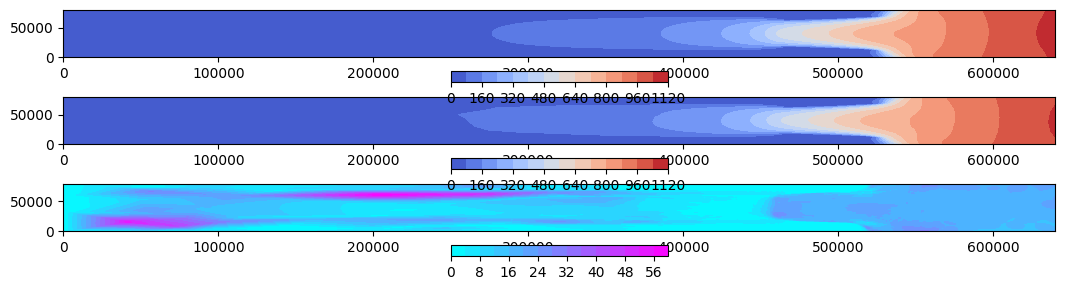

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12.8, 3.2))
im = tricontourf(u_ref, axes=axes[0], **{"cmap": "coolwarm", "levels": 15,})
fig.colorbar(im, orientation="horizontal", pad=0.2)
im = tricontourf(u_ada, axes=axes[1], **{"cmap": "coolwarm", "levels": 15,})
fig.colorbar(im, orientation="horizontal", pad=0.2)
im = tricontourf(diff, axes=axes[2], **{"cmap": "cool", "levels": 15,})
fig.colorbar(im, orientation="horizontal", pad=0.2)

In [17]:
e_u_tilde = np.sqrt(np.sum(np.abs(diff.dat.data)) / len(diff.dat.data))
e_u_tilde

3.964065857931041

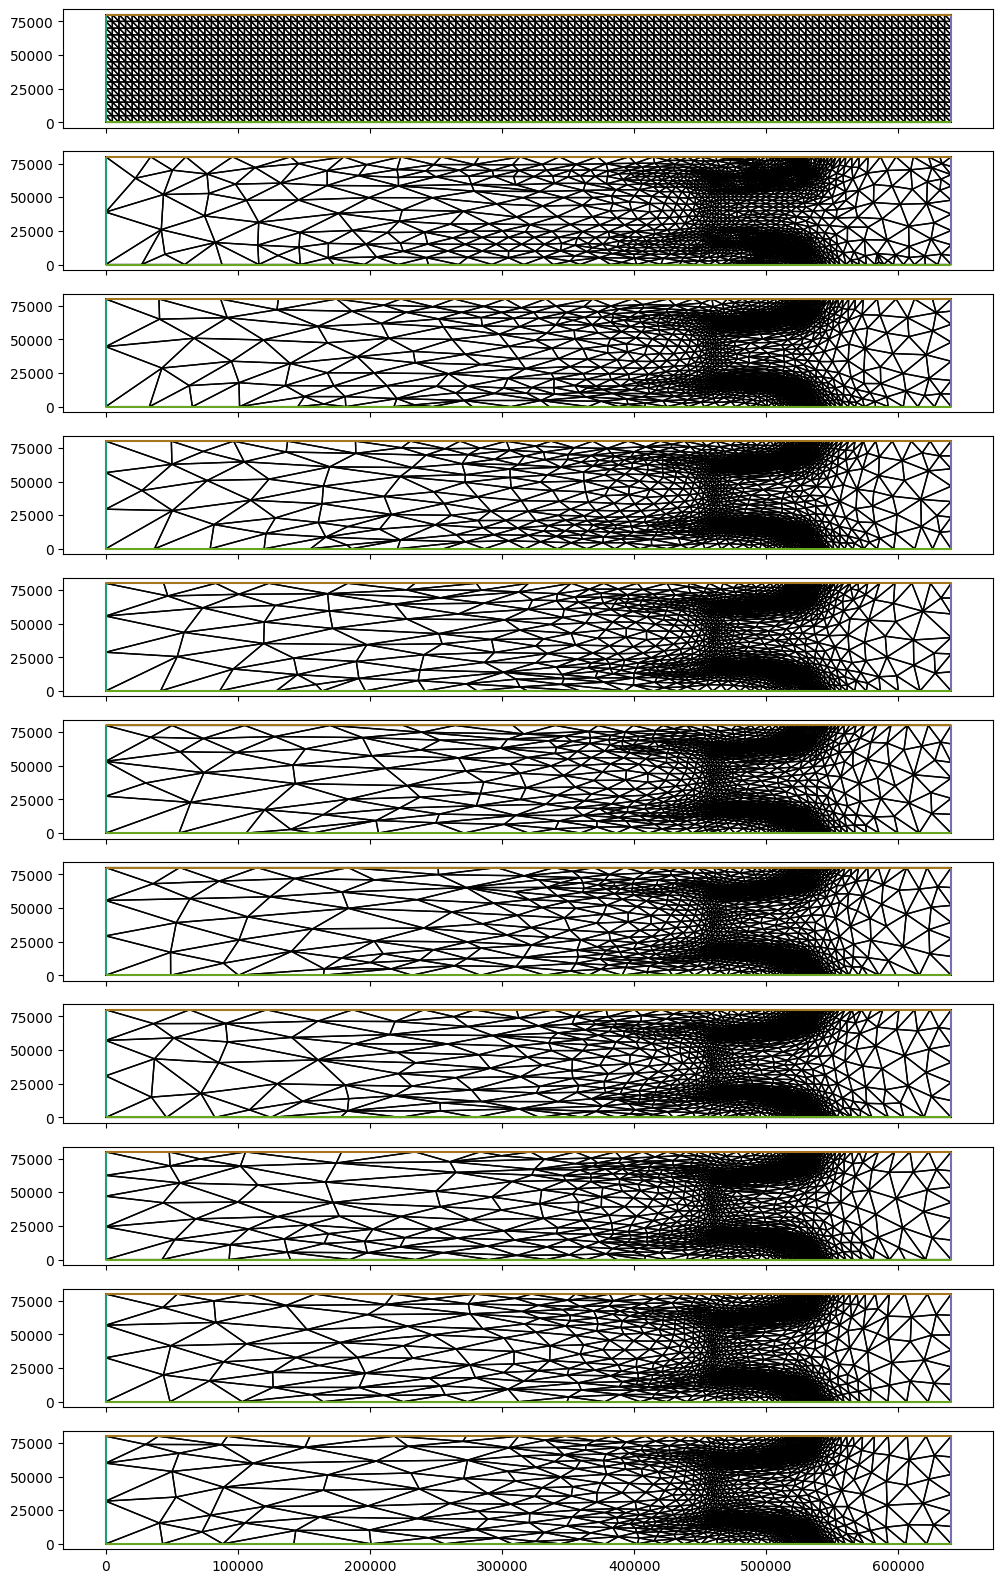

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(meshes), 1, sharex=True, figsize=(12, 20))
for i in range(len(meshes)):
    triplot(meshes[i], axes=axes[i])

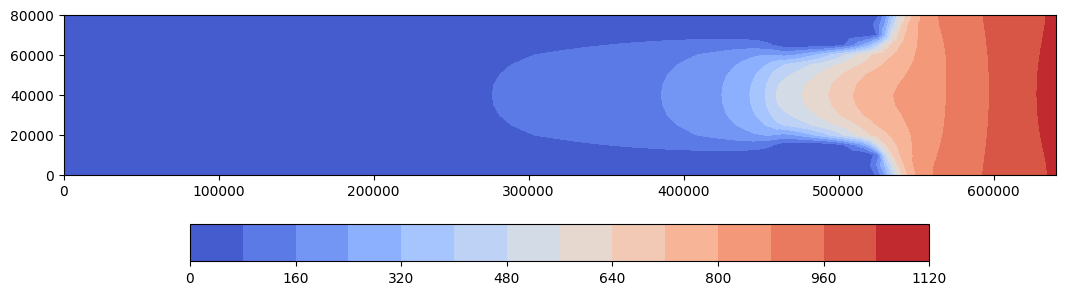

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(12.8, 3.2))
im = tricontourf(u_in, axes=axes, **{"cmap": "coolwarm", "levels": 15,})
fig.colorbar(im, orientation="horizontal", pad=0.2)

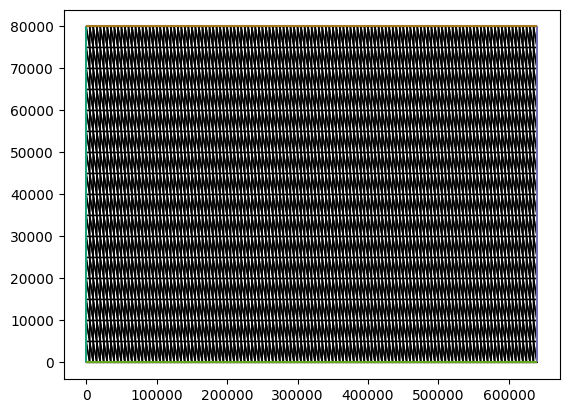

In [14]:
triplot(u_in.function_space().mesh())